In [1]:
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

# Chapter 3. Classification

In the MNIST data set, there are 70,000 images with 784 features ($28 \times 28$ pixels), where each pixel is in the range $[0, 255]$. 

In [2]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')
mnist

{'COL_NAMES': ['label', 'data'],
 'DESCR': 'mldata.org dataset: mnist-original',
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'target': array([0., 0., 0., ..., 9., 9., 9.])}

In [3]:
X, y = mnist ['data'], mnist ['target']
y.shape, X.shape

((70000,), (70000, 784))

Lets take a look at an image. We need to reshape an instance (a row in data), to a $28 \times 28$ array and display it by **Matlablib's imshow()**

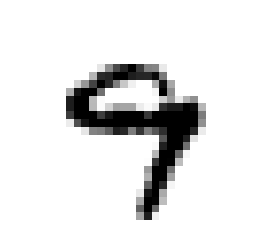

In [4]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

some_digit = X [54321]
some_digit_image = some_digit.reshape (28, 28)

plt.imshow (some_digit_image, cmap = matplotlib.cm.binary, interpolation = 'nearest')

plt.axis ('off')
plt.show()

In [5]:
y [54321]

9.0

MNIST data has already split into a training set (the first 60,000 images) and a test (the last 10,000 images).

In [6]:
X_train, X_test, y_train, y_test = X [:60 * 1000], X [60 * 1000:], y [:60 * 1000], y [60 * 1000:]

We need to shuffle our training set to make sure that cross-validation folds will yield similar results. Moreover, some ML algorithms perform poorly if they get similar instances in a row. It can be done simply with __numpy__

In [7]:
import numpy as np
shuffle_index = np.random.permutation(60 * 1000)
X_train, y_train = X_train [shuffle_index], y_train[shuffle_index]

# Training a Binary Classifier

Lets simplify the problem. Lets decise if the given image is $5$ or not $5$. 

In [8]:
y_train_5 = (y_train == 5) # y_train_5 will be True if for all 5s in y_train; otherwise, False
y_test_5 = (y_test == 5)

Lets pick a training model like **Stochastic Gradient Descent**, which is fast to deal with very large datasets.

In [9]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier (random_state=42)
sgd_clf.fit (X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False)

In [10]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3)

We can use __confusion matrix__ to have a more concise metric. An interesting aspect of confusion matrix is to measure __precision__ and __recall__ metrics of a classifier.
$$\text{Precision} = \frac{\text{TP}}{\text{TP} + \text{FP}}$$
$$\text{Recall (also called sensitivity or true positive rate)} = \frac{\text{TP}}{\text{TP} + \text{FN}}$$
Where __TP__ is the number of True Positives and __FN__ is the number of False Negatives.

Text(34,0.5,'Actual')

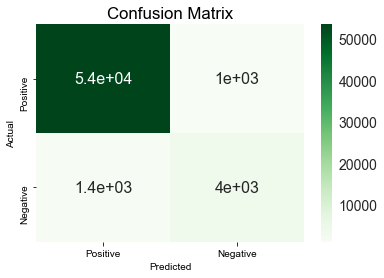

In [11]:
import pandas as pd
import seaborn as sn
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_train_5, y_train_pred)
df_cm = pd.DataFrame(conf_mat, {'Negative', 'Positive'}, {'Negative', 'Positive'})
ax = plt.axes()
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 16}, cmap=plt.get_cmap('Greens'), ax=ax)# font size
ax.set_title('Confusion Matrix')
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')

In [12]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred)

0.7980423491809828

In [13]:
recall_score(y_train_5, y_train_pred)

0.7369489024165283

It is often convenient to combine __precision__ and __recall__ metrics into a single metric called $F_1$ score. This score is a $\textit{harmonic mean}$ of precision and recall function. __Harmonic mean__ gives much more weight to low values. 
$$F_1 = \frac {2}{\frac{1}{\text{Precision}} + \frac{1}{\text{Recall}}} = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}} = \frac{\text{TP}}{{\text{TP} + \frac{\text{FN + FP}}{2}}}$$

In [14]:
from sklearn.metrics import f1_score
f1_score (y_train_5, y_train_pred)

0.7662798503884148

You can't have both metrics: increasing precision reduces recall and vice versa. This is called *precisoin/recall tradeoff*.

## Precision/Recall Tradeoff

__SGDClassifier__ make a decision to classify the data based on the score of a *decision function*. If the score is greater than a __threshold__, it assigns the instance to the positive class, otherwise assigns it to a negative class. __cross_val_predict__ and the classifier gives a score to each instance to show how confidence they are classified. For exmaple, in a binary classifier, there are two types of numbers, positives and negatives. If the number is very large high positve number, the number with high likelihood is in the positive class. 

In [15]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')

In [16]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_true=y_train_5, probas_pred=y_scores)

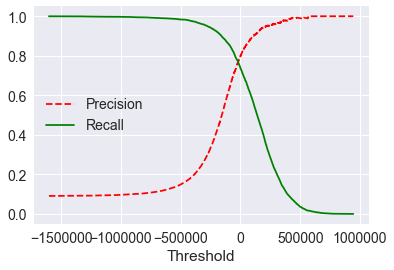

In [17]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'r--', label='Precision')
    plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
    plt.xlabel('Threshold')
    plt.legend(loc='center left')

plot_precision_recall_vs_threshold(precisions=precisions, recalls=recalls, thresholds=thresholds)
plt.show()

Another way to select a good __precision/recall__ tradeoff is to plot precision directly against recall.

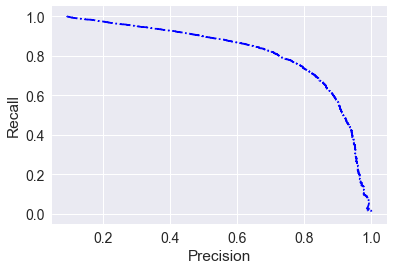

In [18]:
def plot_precision_vs_recall (precisions, recalls):
    plt.plot(precisions, recalls, 'b-.')
    plt.xlabel('Precision')
    plt.ylabel('Recall')

plot_precision_vs_recall(precisions=precisions, recalls=recalls)
plt.show()

You will probably want to select precision/recall tradeoff just before the drop -- for example at around $\%70$ precision. Lets say we need $\%90$ percisoin. By looking at the previous plot, we can find what the threshold is when precision is $\%90$ or we can write a function to an index. 

In [19]:
def find_threshold_for_value(metrics, query, thresholds):
    idx = min(range(len(metrics)), key=lambda i: abs(metrics[i] - query))
    return thresholds[idx]
new_threshold = find_threshold_for_value(metrics=precisions, query=0.90, thresholds=thresholds)
new_threshold

105661.42306474512

In [20]:
y_train_pred_90 = (y_scores > new_threshold)
precision_score(y_train_5, y_train_pred_90)

0.8999707516817783

In [21]:
recall_score(y_train_5, y_train_pred_90)

0.5676074524995388

In [22]:
find_threshold_for_value(metrics=recalls, query=0.6458218040951854, thresholds=thresholds) # this is just for validation

59402.67892736697

# ROC Curve

The Receiver Operating Characteristic (ROC) curve is a common tool to measure the accuracy of a binary classifier. The more the curve is close to the top-left corner of the plot, the higher the accuracy is. 

In [23]:
print(y_train_5)
print(y_scores)

[False False False ... False False False]
[-556172.17077887 -454216.24064986 -251679.66086588 ... -452654.4889547
 -331722.44451667 -488389.64186591]


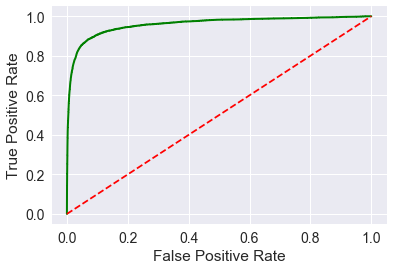

In [24]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve (fpr, tpr, label=None):
    plt.plot (fpr, tpr, 'g-', linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

plot_roc_curve(fpr, tpr)

One way to compare the classifiers is to measure the *area under the curve* __AUC__. A perfect classifier has a __ROC AUC__ equal to $1$, where a purely random classifier will have a __ROC AUC__ equal to $0.5$. 

In [25]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9589927709431337

However, this does not necessarily show that the classifier is good. This is because there are too many non-5s (or negatives) compared to few 5s (positives). 

We can train a __RandomForestClassifier__ and compare its __ROC__ curive and __ROC AUC__ score to the __SGDClassifier__. But the way __RandomForestClassifier__ works is different. It uses __predict_proba()__ which computes the probability that an instance belongs to a class.

In [26]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict (forest_clf, X_train, y_train_5, cv=3, method='predict_proba')

In [27]:
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

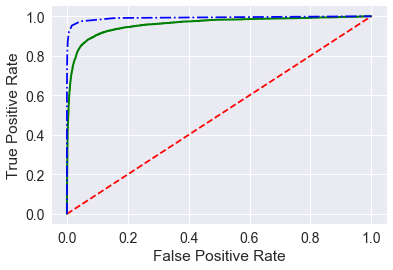

In [28]:
plot_roc_curve(fpr, tpr)
plt.plot(fpr_forest, tpr_forest, 'b-.', label='Random Forest')

In [29]:
roc_auc_score(y_train_5, y_scores_forest)

0.9917702443840056

# Multiclass Classification

We can take advantage of binary classifiers to apply them for multi classifications. One way to do so is __OvA__. For example to classify images into $10$ classes (for $10$ digits), we can run $10$ binary classifications for each digit and then report the digit with highest score for a given image. 
Another method is called __OvO__ (_one versus one_). In this method, we can distinguish a pair of classifications together and then we can see which class for a given image wins the most of duels. 

__Scikit-learn__ detects when you try to use a binary classification algorithm for a multiclass classification task, and it autmotaically runs __OvA__, except for __SVM__ that it uses __OvO__. Lets try __SGDClassifier__ as a multiclass classification algorithm.

In [30]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([9.])

Lets see decision scores made by __SGDClassifier__ with calling __decision_function()__.

In [31]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[-525205.12360604, -916158.98338404, -820750.04670839,
        -635890.68095   ,   36153.36075756, -348361.62569669,
        -136935.05306562, -152088.9892626 , -543099.77553503,
         253633.55626804]])

In [32]:
np.argmax(some_digit_scores)

9

In [33]:
sgd_clf.classes_

array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.])

If you want to force __scikitLearn__ to use __OvO__ or __OvO__, you can use __OneVsOneClassifier__ or __OneVsRestClassifier__ classes respectively.

In [34]:
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

array([9.])

In [35]:
len(ovo_clf.estimators_)

45

In [36]:
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array([9.])

In [37]:
len(forest_clf.estimators_)

10

This time __Scikit_Learn__ did not have __OvA__ or __OvO__ because Random Forest Classifiers can directly classify instances into multiple classes. You can call __predict_proba()__ to get the list of probabilities that the classifier assigned to the given instance for each class.

In [38]:
forest_clf.predict_proba([some_digit])

array([[0. , 0. , 0. , 0. , 0. , 0. , 0.1, 0. , 0. , 0.9]])

Lets here evaluate different multiclass classification algorithms

In [39]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy')

array([0.86237752, 0.85874294, 0.86372956])

We can increase the accuracy if we scale the inputs.

In [40]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform (X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.90941812, 0.91289564, 0.90908636])

In [41]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv = 3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5738,    2,   23,    9,   10,   47,   41,   11,   39,    3],
       [   2, 6467,   51,   25,    5,   42,    5,   10,  121,   14],
       [  58,   35, 5334,  102,   75,   25,  101,   56,  155,   17],
       [  48,   34,  131, 5356,    3,  227,   34,   56,  141,  101],
       [  21,   25,   41,    9, 5373,   11,   55,   21,   82,  204],
       [  66,   38,   36,  179,   75, 4604,  104,   29,  179,  111],
       [  30,   22,   48,    2,   44,   82, 5632,    7,   50,    1],
       [  23,   20,   73,   29,   60,   11,    6, 5778,   14,  251],
       [  53,  149,   76,  156,   14,  146,   60,   29, 5031,  137],
       [  42,   27,   25,   87,  160,   28,    2,  172,   91, 5315]],
      dtype=int64)

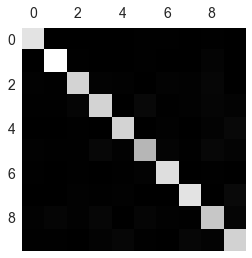

In [42]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.grid(False)

This confusion matrix looks fairly good since most of the images are on the main diagonal, which means they are classified correctly. 

In [43]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
row_sums

array([[5923],
       [6742],
       [5958],
       [6131],
       [5842],
       [5421],
       [5918],
       [6265],
       [5851],
       [5949]], dtype=int64)

In [44]:
norm_conf_mx = conf_mx / row_sums

Lets fill the diagonal with zero to show only the errors.

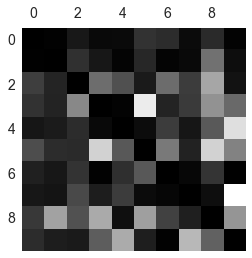

In [45]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.grid(False)
plt.show()

Notice that the matrix is not symmetrical. For example, there are many __5s__ that are predicted as __8s__ while the inverse is less. 

Analyzing individual errors can be also useful. 

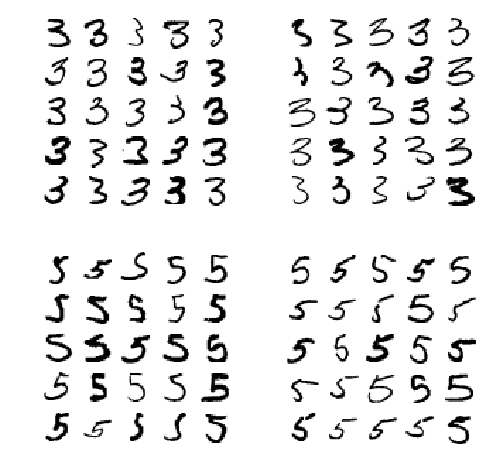

In [46]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1 # get the floor division
    row_images = []
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=0))
    image = np.concatenate(row_images, axis=1)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")

cl_a, cl_b = 3, 5
X_aa = X_train [(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train [(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train [(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train [(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)

# Multilabel Classificaiton

Until now, each instance is assigned to just one class. In some cases, you may want classifier to output multiple classes for each instance. 

In [47]:
from sklearn.neighbors import KNeighborsClassifier
y_train_small = (y_train < 5)
y_train_odd = (y_train % 2 == 1)
y_multiple = np.c_[y_train_small, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multiple)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

Here, we classify each instance based on two targets. First, it indicates that whether or not the digit is smaller than 5; second, it indicates whether the number is odd or not.

In [48]:
knn_clf.predict([some_digit])

array([[False,  True]])

It depends on the project to select the best metric to evaluate a classifier. One approach is to measure the $F_1$ score for each individual and then simply compute the average scores for each label of target.

In [49]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_train, cv=3)
f1_score(y_multiple, y_train_knn_pred, average='macro')

KeyboardInterrupt: 

However, it measures that all labels are equally important, which may not be the case. One may give each label a weight equal to its support to each. To do this, we can simply set __average='weighted'__.

# Multioutput Classification

It is a generalization of __multilabel classification__, where each label may have more than two values. We add some noise to each picture and our target is to find a clean image.

In [50]:
noise = np.random.randint (0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint (0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

In [ ]:
def  plot_digit (data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = matplotlib.cm.binary, interpolation="nearest")
    plt.axis("off")

some_index = 1234
knn_clf.fit (X_train_mod, y_train_mod)
noisy_digit = [X_test_mod[some_index]]
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)
plot_digit(noisy_digit)